In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy.stats import norm, t


In [44]:
df = pd.read_csv("/home/hujianjin/projects/LinearRegression_XAUUSD/price_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [45]:
# Feature engineering

# Short-term trend (3-week SMA)
df['SMA_3'] = df['Close'].rolling(window=3).mean()
# Long-term trend (5-week SMA)
df['SMA_5'] = df['Close'].rolling(window=5).mean()
# Percentage change (2 weeks)
df['Pct_Change_2w'] = df['Close'].pct_change(periods=2)
# Volatility (High-Low relative to Open)
df['Volatility'] = (df['High'] - df['Low']) / df['Open']
# Rolling 3-week volatility (std dev of Close)
df['Volatility_3w'] = df['Close'].rolling(window=3).std()
# Low to Open ratio
df['Low_Open_ratio'] = df['Low'] / df['Open']
# Volume change from previous week
df['Volume_Change'] = df['Tick_Vol'] - df['Tick_Vol'].shift(1)
# Volatility normalized by tick volume
df['Volatility_per_Tick'] = df['Volatility'] / df['Tick_Vol']
# Momentum Low (1 week)
df['Momentum_1w_Low'] = df['Low'] - df['Low'].shift(1)
# Momentum Low (2 weeks)
df['Momentum_2w_Low'] = df['Low'] - df['Low'].shift(2)
# Lagged Low price (1 week)
df['Low_lag1'] = df['Low'].shift(1)
# Intraperiod downward movement relative to Close
df['Low_Close_gap_pct'] = (df['Low'] - df['Close']) / df['Close']
# Min Low over last 3 weeks (potential breakout indicator)
df['Min_Low_3w'] = df['Low'].rolling(window=3).min()
# Target variable: Next week's Low price
df['Low_price_next_week'] = df['Low'].shift(-1)


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 286 entries, 2020-01-05 to 2025-06-22
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Open                 286 non-null    float64
 1   High                 286 non-null    float64
 2   Low                  286 non-null    float64
 3   Close                286 non-null    float64
 4   Tick_Vol             286 non-null    int64  
 5   SMA_3                284 non-null    float64
 6   SMA_5                282 non-null    float64
 7   Pct_Change_2w        284 non-null    float64
 8   Volatility           286 non-null    float64
 9   Volatility_3w        284 non-null    float64
 10  Low_Open_ratio       286 non-null    float64
 11  Volume_Change        285 non-null    float64
 12  Volatility_per_Tick  286 non-null    float64
 13  Momentum_1w_Low      285 non-null    float64
 14  Momentum_2w_Low      284 non-null    float64
 15  Low_lag1             

In [47]:
df

,Open,High,Low,Close,Tick_Vol,SMA_3,SMA_5,Pct_Change_2w,Volatility,Volatility_3w,Low_Open_ratio,Volume_Change,Volatility_per_Tick,Momentum_1w_Low,Momentum_2w_Low,Low_lag1,Low_Close_gap_pct,Min_Low_3w,Low_price_next_week
Date,,,,,,,,,,,,,,,,,,,
2020-01-05,1558.650,1611.25,1540.170,1562.03,417142,NaN,NaN,NaN,0.045604,NaN,0.988144,NaN,1.093238e-07,NaN,NaN,NaN,-0.013995,NaN,1535.850
2020-01-12,1559.911,1561.44,1535.850,1557.00,288879,NaN,NaN,NaN,0.016405,NaN,0.984575,-128263.0,5.678773e-08,-4.320,NaN,1540.170,-0.013584,NaN,1546.290
2020-01-19,1557.520,1575.73,1546.290,1571.42,263672,1563.483333,NaN,0.006011,0.018902,7.319032,0.992790,-25207.0,7.168696e-08,10.440,6.120,1535.850,-0.015992,1535.85,1563.305
2020-01-26,1581.140,1590.29,1563.305,1589.20,368721,1572.540000,NaN,0.020681,0.017067,16.129191,0.988720,105049.0,4.628649e-08,17.015,27.455,1546.290,-0.016294,1535.85,1547.440
2020-02-02,1590.810,1591.88,1547.440,1570.07,347703,1576.896667,1569.944,-0.000859,0.027935,10.676359,0.972737,-21018.0,8.034286e-08,-15.865,1.150,1563.305,-0.014413,1546.29,1561.830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-25,3354.940,3356.54,3245.190,3288.34,1068819,3281.773333,3280.814,0.027234,0.033190,77.538827,0.967287,-125606.0,3.105284e-08,40.950,124.770,3204.240,-0.013122,3120.42,3295.220
2025-06-01,3298.240,3403.46,3295.220,3309.83,1182423,3317.996667,3295.504,-0.013705,0.032818,34.473300,0.999084,113604.0,2.775445e-08,50.030,90.980,3245.190,-0.004414,3204.24,3293.460
2025-06-08,3310.530,3446.75,3293.460,3431.88,1159543,3343.350000,3317.406,0.043651,0.046304,77.418510,0.994844,-22880.0,3.993277e-08,-1.760,48.270,3295.220,-0.040334,3245.19,3340.270


In [48]:
# Drop unnecessary columns and rows with NaN values
df1 = (
    df.drop(
        columns=[
            'Open', 'High', 'Low', 'Close', 'Tick_Vol'
        ],
        axis=1
    )
    .dropna()
)

In [49]:
df2 = df[-1:]  # Keep the last row for prediction

In [50]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281 entries, 2020-02-02 to 2025-06-15
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SMA_3                281 non-null    float64
 1   SMA_5                281 non-null    float64
 2   Pct_Change_2w        281 non-null    float64
 3   Volatility           281 non-null    float64
 4   Volatility_3w        281 non-null    float64
 5   Low_Open_ratio       281 non-null    float64
 6   Volume_Change        281 non-null    float64
 7   Volatility_per_Tick  281 non-null    float64
 8   Momentum_1w_Low      281 non-null    float64
 9   Momentum_2w_Low      281 non-null    float64
 10  Low_lag1             281 non-null    float64
 11  Low_Close_gap_pct    281 non-null    float64
 12  Min_Low_3w           281 non-null    float64
 13  Low_price_next_week  281 non-null    float64
dtypes: float64(14)
memory usage: 32.9 KB


In [51]:
df1

,SMA_3,SMA_5,Pct_Change_2w,Volatility,Volatility_3w,Low_Open_ratio,Volume_Change,Volatility_per_Tick,Momentum_1w_Low,Momentum_2w_Low,Low_lag1,Low_Close_gap_pct,Min_Low_3w,Low_price_next_week
Date,,,,,,,,,,,,,,
2020-02-02,1576.896667,1569.944,-0.000859,0.027935,10.676359,0.972737,-21018.0,8.034286e-08,-15.865,1.150,1563.305,-0.014413,1546.29,1561.83
2020-02-09,1580.926667,1574.240,-0.003580,0.014686,9.823158,0.993783,-74435.0,5.374091e-08,14.390,-1.475,1547.440,-0.013691,1547.44,1578.80
2020-02-16,1598.883333,1591.454,0.046495,0.044447,38.852343,0.997914,33097.0,1.450794e-07,16.970,31.360,1561.830,-0.039116,1547.44,1562.76
2020-02-23,1604.033333,1594.274,0.001269,0.076510,33.821680,0.945265,342761.0,1.178660e-07,-16.040,0.930,1578.800,-0.014355,1561.83,1575.28
2020-03-01,1633.966667,1611.096,0.018405,0.073311,44.597355,0.990014,-94911.0,1.322787e-07,12.520,-3.520,1562.760,-0.058584,1562.76,1504.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-18,3293.116667,3286.262,0.010068,0.050235,81.374118,0.996504,-119125.0,4.205799e-08,83.820,-32.250,3120.420,-0.045169,3120.42,3245.19
2025-05-25,3281.773333,3280.814,0.027234,0.033190,77.538827,0.967287,-125606.0,3.105284e-08,40.950,124.770,3204.240,-0.013122,3120.42,3295.22
2025-06-01,3317.996667,3295.504,-0.013705,0.032818,34.473300,0.999084,113604.0,2.775445e-08,50.030,90.980,3245.190,-0.004414,3204.24,3293.46


In [52]:
# features selection
features = [
    'SMA_3', 'SMA_5',
    'Pct_Change_2w', 'Volatility',
    'Volatility_3w', 'Low_Open_ratio', 'Volume_Change',
    'Volatility_per_Tick', 'Momentum_1w_Low', 'Momentum_2w_Low', 'Low_lag1',
    'Low_Close_gap_pct', 'Min_Low_3w'
]

In [53]:
# Select features and target
X = df1[features].values
y = df1['Low_price_next_week'].values

In [54]:
# Final Holdout Split (80% train, 20% test)
split_index = int(len(X) * 0.8)

X_train_full, X_test = X[:split_index], X[split_index:]
y_train_full, y_test = y[:split_index], y[split_index:]

In [55]:
# Display information about the datasets
print(f"X_train_full shape: {X_train_full.shape}")
print(f"y_train_full shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_shape: {y_test.shape}")

X_train_full shape: (224, 13)
y_train_full shape: (224,)
X_test shape: (57, 13)
y_test_shape: (57,)


In [56]:
# Scale numeric features
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

In [57]:
# Initialize TimeSeriesSplit for model evaluation
# no hyperparameter tuning in this example
tscv = TimeSeriesSplit(n_splits=5)

# Lists to store scores
mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

# Time series cross-validation loop
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full_scaled)):
    X_train_scaled, X_val_scaled = X_train_full_scaled[train_idx], X_train_full_scaled[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)

    # Compute metrics
    mae = mean_absolute_error(y_val, y_val_pred)
    mse = mean_squared_error(y_val, y_val_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)*100
    r2 = r2_score(y_val, y_val_pred)

    # Store scores
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    r2_scores.append(r2)

    print(f"Fold {fold + 1}: MAE = {mae:.4f}, MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAPE = {mape:.4f}, R² = {r2:.4f}")

# Print average scores
print("\nAverage CV Scores:")
print(f"MAE:  {np.mean(mae_scores):.4f}")
print(f"MSE:  {np.mean(mse_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f}")
print(f"MAPE: {np.mean(mape_scores):.4f}")
print(f"R²:   {np.mean(r2_scores):.4f}")


Fold 1: MAE = 37.3251, MSE = 1989.7711, RMSE = 44.6068, MAPE = 2.1048, R² = 0.3400
Fold 2: MAE = 25.9425, MSE = 1207.8369, RMSE = 34.7539, MAPE = 1.4543, R² = 0.7201
Fold 3: MAE = 21.2575, MSE = 759.7417, RMSE = 27.5634, MAPE = 1.2203, R² = 0.8895
Fold 4: MAE = 21.8656, MSE = 653.8730, RMSE = 25.5709, MAPE = 1.1475, R² = 0.7700
Fold 5: MAE = 25.1408, MSE = 825.4888, RMSE = 28.7313, MAPE = 1.2117, R² = 0.9623

Average CV Scores:
MAE:  26.3063
MSE:  1087.3423
RMSE: 32.2453
MAPE: 1.4277
R²:   0.7364


In [58]:
# Fit model on Full Training Set
model.fit(X_train_full_scaled, y_train_full)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [59]:
# Prediction on full training set
y_train_full_pred = model.predict(X_train_full_scaled)

In [60]:
# Prediction on Test Set
y_test_pred = model.predict(X_test_scaled)

In [61]:
results = pd.DataFrame({
    "predicted": y_test_pred,          # model's predicted low prices
    "actual": y_test                   # actual low prices
})
print(results)

      predicted    actual
0   2301.814083  2320.429
1   2292.100119  2286.610
2   2264.732239  2287.609
3   2297.342538  2306.499
4   2288.045297  2293.489
5   2298.092965  2318.417
6   2342.807125  2349.309
7   2375.636408  2393.670
8   2360.846912  2353.030
9   2352.252467  2369.559
10  2395.100429  2364.206
11  2399.220061  2423.699
12  2444.547355  2470.799
13  2480.083879  2493.539
14  2471.333174  2471.758
15  2465.360404  2485.429
16  2522.590655  2546.779
17  2576.927221  2613.739
18  2614.110023  2624.569
19  2618.046628  2600.589
20  2622.691839  2637.990
21  2665.669907  2708.720
22  2712.038700  2724.619
23  2698.807524  2644.690
24  2660.577064  2537.650
25  2549.368435  2560.790
26  2637.816791  2606.199
27  2624.415326  2614.030
28  2609.163583  2627.695
29  2599.824867  2581.689
30  2594.695552  2608.300
31  2585.440532  2596.129
32  2605.300096  2615.544
33  2646.593959  2656.760
34  2662.177016  2689.345
35  2711.333241  2730.834
36  2746.803661  2772.100
37  2798.261

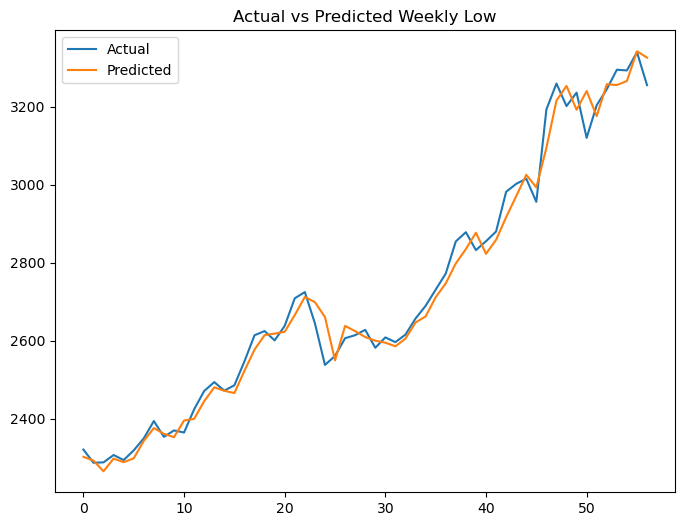

In [62]:
# Plot actual vs predicted line chart on test set
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title("Actual vs Predicted Weekly Low")
plt.legend()
plt.show()

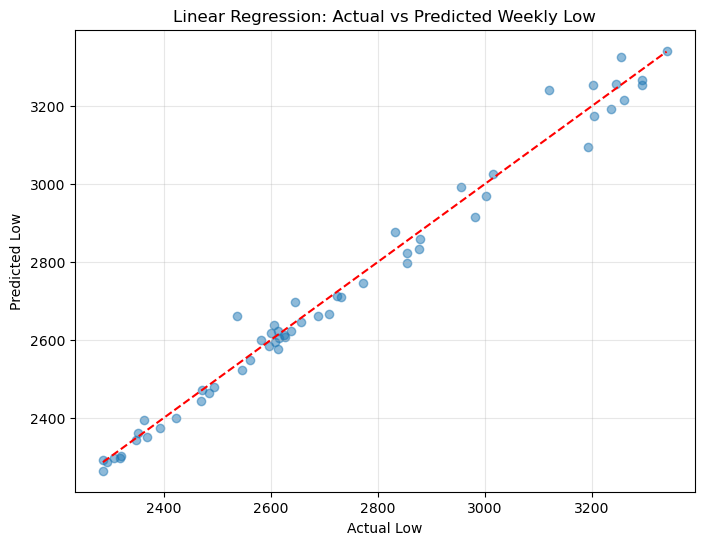

In [63]:
# Plot actual vs predicted scatter plot on test set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Low')
plt.ylabel('Predicted Low')
plt.title('Linear Regression: Actual vs Predicted Weekly Low')
plt.grid(True, alpha=0.3)

In [64]:
# Compute performance metrics on test data

model_test_mae = mean_absolute_error(y_test, y_test_pred)
model_test_mse = mean_squared_error(y_test, y_test_pred)
model_test_rmse = np.sqrt(model_test_mse)
model_test_mape = mean_absolute_percentage_error(y_test, y_test_pred)*100
model_test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Linear Regression Performance on Test Data:")
print(f"Model - MAE:  {model_test_mae:.3f}")
print(f"        MSE:  {model_test_mse:.3f}")
print(f"        RMSE: {model_test_rmse:.3f}")
print(f"        MAPE: {model_test_mape:.3f}")
print(f"        R²:   {model_test_r2:.3f}")

Linear Regression Performance on Test Data:
Model - MAE:  29.328
        MSE:  1509.254
        RMSE: 38.849
        MAPE: 1.047
        R²:   0.985


In [65]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2025-06-22 to 2025-06-22
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Open                 1 non-null      float64
 1   High                 1 non-null      float64
 2   Low                  1 non-null      float64
 3   Close                1 non-null      float64
 4   Tick_Vol             1 non-null      int64  
 5   SMA_3                1 non-null      float64
 6   SMA_5                1 non-null      float64
 7   Pct_Change_2w        1 non-null      float64
 8   Volatility           1 non-null      float64
 9   Volatility_3w        1 non-null      float64
 10  Low_Open_ratio       1 non-null      float64
 11  Volume_Change        1 non-null      float64
 12  Volatility_per_Tick  1 non-null      float64
 13  Momentum_1w_Low      1 non-null      float64
 14  Momentum_2w_Low      1 non-null      float64
 15  Low_lag1             1 

In [66]:
# last row features selection
features = [
    'SMA_3', 'SMA_5',
    'Pct_Change_2w', 'Volatility',
    'Volatility_3w', 'Low_Open_ratio', 'Volume_Change',
    'Volatility_per_Tick', 'Momentum_1w_Low', 'Momentum_2w_Low', 'Low_lag1',
    'Low_Close_gap_pct', 'Min_Low_3w'
]
X_last = df2[features]

In [67]:
# Scale the last row features
X_last_scaled = scaler.transform(X_last)
# Predict the next week's close price
predicted_next = model.predict(X_last_scaled)
# Extract scalar value from the prediction
predicted_next = predicted_next[0]
print(f"Predicted XAUUSD Weekly Low for the week of <2025-06-29>: {predicted_next:.3f}")


Predicted XAUUSD Weekly Low for the week of <2025-06-29>: 3248.630


/home/hujianjin/miniconda3/envs/forecasting_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


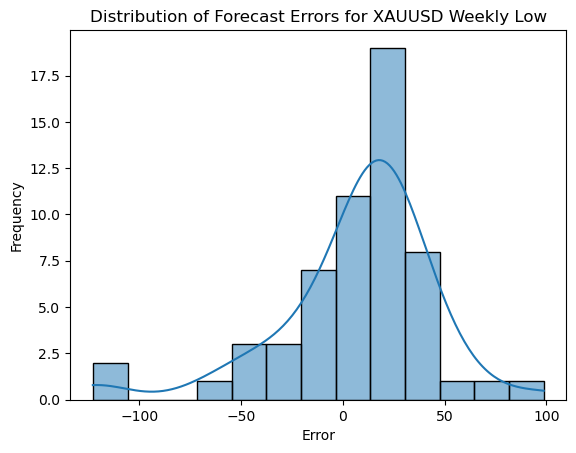

In [68]:
# Histogram + density curve of forecast errors
errors = y_test - y_test_pred  # residuals/errors
sns.histplot(errors, kde=True)
plt.title("Distribution of Forecast Errors for XAUUSD Weekly Low")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

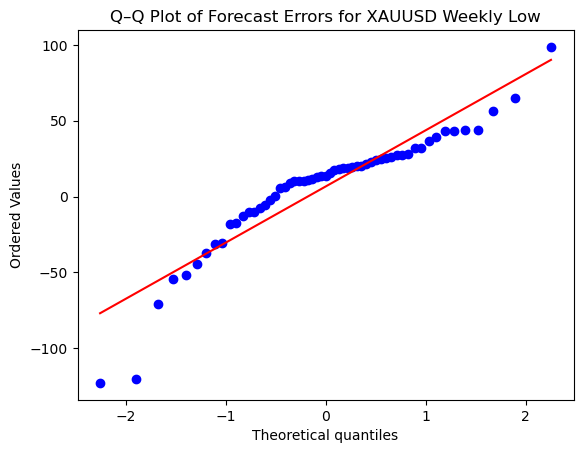

In [69]:
# Q–Q Plot of forecast errors
stats.probplot(errors, dist="norm", plot=plt)
plt.title("Q–Q Plot of Forecast Errors for XAUUSD Weekly Low")
plt.show()


In [70]:
from scipy.stats import t, norm

def probabilistic_ranges(predicted_price, rmse, mape, confidence=0.68, n=None):
    """
    Calculate RMSE-based and MAPE-based probabilistic ranges for a predicted value.
    Automatically uses t-distribution if sample size (n) is provided and n < 100.
    """
    # Ensure MAPE is in decimal form
    if mape > 1:
        mape = mape / 100.0
    
    # Choose correct distribution for critical value
    if n is not None and n < 100:
        z_or_t = t.ppf(0.5 + confidence / 2, df=n - 1)
        dist_used = "t-distribution"
    else:
        z_or_t = norm.ppf(0.5 + confidence / 2)
        dist_used = "z-distribution"
    
    # --- RMSE-based ---
    rmse_margin = z_or_t * rmse
    rmse_lower = predicted_price - rmse_margin
    rmse_upper = predicted_price + rmse_margin
    
    # --- MAPE-based ---
    sigma_pct = mape / 0.8  # Approx std dev of % errors
    mape_margin_pct = z_or_t * sigma_pct
    mape_lower = predicted_price * (1 - mape_margin_pct)
    mape_upper = predicted_price * (1 + mape_margin_pct)
    
    return {
        "confidence": confidence,
        "critical_value": z_or_t,
        "distribution_used": dist_used,
        "rmse_based": {
            "margin_abs": rmse_margin,
            "lower": rmse_lower,
            "upper": rmse_upper
        },
        "mape_based": {
            "margin_pct": mape_margin_pct * 100,  # in %
            "lower": mape_lower,
            "upper": mape_upper
        }
    }

# Next week's actual low and prediction range
actual_price = 3243.830
predicted_price = 3248.630
rmse = 38.849
mape = 1.047  # in %
n = 57  # size of test dataset

ranges = probabilistic_ranges(predicted_price, rmse, mape, confidence=0.68, n=n)

print(f"--- {ranges['confidence']*100:.0f}% Probabilistic Ranges ({ranges['distribution_used']}) ---")
print(f"RMSE-based: {ranges['rmse_based']['lower']:.2f} – {ranges['rmse_based']['upper']:.2f} "
      f"(±{ranges['rmse_based']['margin_abs']:.2f})")
print(f"MAPE-based: {ranges['mape_based']['lower']:.2f} – {ranges['mape_based']['upper']:.2f} "
      f"(±{ranges['mape_based']['margin_pct']:.2f}%)")



--- 68% Probabilistic Ranges (t-distribution) ---
RMSE-based: 3209.65 – 3287.61 (±38.98)
MAPE-based: 3205.97 – 3291.29 (±1.31%)


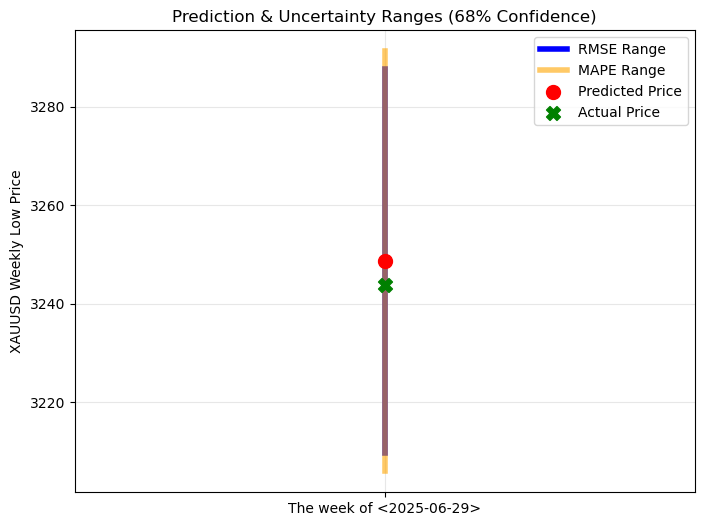

In [71]:
# Extract values from the ranges dictionary
rmse_lower = ranges['rmse_based']['lower']
rmse_upper = ranges['rmse_based']['upper']
mape_lower = ranges['mape_based']['lower']
mape_upper = ranges['mape_based']['upper']

# X-axis will just be a placeholder for the prediction point
x_pos = 0

plt.figure(figsize=(8, 6))

# --- RMSE-based range ---
plt.plot([x_pos, x_pos], [rmse_lower, rmse_upper], color='blue', linewidth=4, label='RMSE Range')

# --- MAPE-based range ---
plt.plot([x_pos, x_pos], [mape_lower, mape_upper], color='orange', linewidth=4, alpha=0.6, label='MAPE Range')

# --- Predicted price ---
plt.scatter(x_pos, predicted_price, color='red', s=100, zorder=3, label='Predicted Price')

# --- Actual price ---
plt.scatter(x_pos, actual_price, color='green', s=100, zorder=3, marker='X', label='Actual Price')

# Labels and legend
plt.xticks([x_pos], ['The week of <2025-06-29>'])
plt.ylabel('XAUUSD Weekly Low Price')
plt.title(f"Prediction & Uncertainty Ranges ({ranges['confidence']*100:.0f}% Confidence)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()
